# Evaluation of Analyzers using Input Perturbations

This notebook will guide you through an example of how to evaluate analyzers via perturbing the input according to the importance that the analysis method attribute to input regions.

The input images are divided into quadratic regions that are sorted according to their importance w.r.t. to the pixel-wise saliency scores assigned by those analyzers. Then, the information content of the image is gradually destroyed by perturbation of the most important regions. The effect of this perturbation on the classifier performance is measured. This procedure is repeated several times.

We expect that the classifier performance drops quickly if important information is removed and remains largely unaffected when perturbing unimportant regions.

Thus, different analyzers can be compared by measuring how quickly their performance drops, i.e. the quicker the classifier performance drops after input perturbation w.r.t. to the prediction analysis, the better the analyzer is capable of identifying the input components responsible for the output of the model.

Similarly, several models can be compared, e.g. with random perturbations on the data, towards their resilience to noisy input data: The faster the model prediction declines with ongoing perturbations, the more susceptible the classifier is to noise.

Reference:

*[Samek et al.](http://dx.doi.org/10.1109/TNNLS.2016.2599820)*, "Evaluating the visualization of what a deep neural network has learned." *IEEE transactions on neural networks and learning systems* 28.11 (2017): 2660-2673.

-----

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

# Imports

In [12]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%matplotlib inline  

import imp
import matplotlib.pyplot as plt
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.utils as iutils

from innvestigate.tools import Perturbation, PerturbationAnalysis

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

# Data
Then, the MNIST data is loaded in its entirety, formatted according to the specifications of the Keras backend.

In [14]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

# Model
We have prepared an (extendable) dictionary of neural network architectures to play around with, some of which are already pre-trained and some which have not seen any `MNIST` data yet.

In [15]:
#         MODELNAME                      INPUT RANGE   EPOCHS   BATCH_SZ   MODEL CREATION KWARGS
models = {'mlp_2dense':                  ([-1, 1],     15,      128,       {'dense_units':1024, 'dropout_rate':0.25}),
          'mlp_3dense':                  ([-1, 1],     20,      128,       {'dense_units':1024, 'dropout_rate':0.25}),
          'cnn_2convb_2dense':           ([-.5, .5],   20,      64,        {}),

          # pre-trained model from [https://doi.org/10.1371/journal.pone.0130140 , http://jmlr.org/papers/v17/15-618.html]
          'pretrained_plos_long_relu':   ([-1, 1],     0,       0,         {}),
          'pretrained_plos_short_relu':  ([-1, 1],     0,       0,         {}),
          'pretrained_plos_long_tanh':   ([-1, 1],     0,       0,         {}),
          'pretrained_plos_short_tanh':  ([-1, 1],     0,       0,         {}),
          }
#Adapt and Play around!

You can select one of the above models by setting the variable `modelname` as below. The corresponding parameters regarding expected input data range, number of training epochs and optional model definition parameters will be fetched from the dictionary.

In [16]:
# Unpack model params by name. The line below currently selects an already pretrained network, which saves some time.
modelname = 'pretrained_plos_long_relu'
input_range, epochs, batch_size, kwargs = models[modelname]

Now, preprocess the data according to the requirements of the model, build the model, optionally train it for `epochs` epochs and then test it.

In [17]:
x_test, y_test = data[2:]
y_test = keras.utils.to_categorical(y_test, num_classes)
test_sample = np.copy(x_test[0:1])
generator = iutils.BatchSequence([x_test, y_test], batch_size=256)

model = mnistutils.create_model(modelname, **kwargs)
scores = mnistutils.train_model(model, data, batch_size=batch_size, epochs=epochs)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Scores on test set: loss=0.029667358092008135 accuracy=0.9917


# Perturbation Analysis

### Setup analyzer and perturbation
The perturbation analysis takes several parameters:
* `perturbation_function`: This is the method with which the pixels in the most important regions are perturbated. You can pass your own function or pass a string to select one of the predefined functions, e.g. "zeros", "mean" or "gaussian".
* `region_shape`: The shape of the regions that are considered for perturbation. In this case, we use single pixels. Regions are aggregated ("pooled") using a (customizable) aggregation function that is average pooling by default. The input image is padded such that it can be subdivided into an integer number of regions.
* `steps`: Number of perturbation steps. 
* `regions_per_step`: In each perturbation step, the `regions_per_step` regions are perturbed.

Feel free to play around with different analyzers, e.g. by selecting them from the `methods` list via `selected_methods_indices`.

In [19]:
perturbation_function = "gaussian"
region_shape  = (7, 7) 
steps = 15
regions_per_step = 1  # Perturbate 1 region per step

# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

nscale = (input_range[1]-input_range[0]) * 0.1

methods = [
    # NAME                    OPT.PARAMS               POSTPROC FXN                TITLE
    ("random",                {},                       mnistutils.graymap,         "Random"),

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,         "Gradient"),
    ("smoothgrad",            {"noise_scale": nscale,
                               "postprocess": "square"},mnistutils.graymap,         "SmoothGrad"),
    ("integrated_gradients",  {"postprocess": "abs"},   mnistutils.graymap,         "Integrated Gradients"),

    # Interaction
    ("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,         "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,         "DeepTaylor"),
    ("input_t_gradient",      {},                       mnistutils.heatmap,         "Input * Gradient"),
    ("lrp.z",                 {},                       mnistutils.heatmap,         "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,         "LRP-Epsilon"),
    ("lrp.sequential_preset_a",{},                      mnistutils.heatmap,         "LRP-PresetA"),
    ("lrp.sequential_preset_b",{"epsilon": 1},          mnistutils.heatmap,         "LRP-PresetB"),
]

# Select methods of your choice
selected_methods_indices = [0, 1, 2, 6]
selected_methods = [methods[i] for i in selected_methods_indices]
print('Using method(s) "{}".'.format([method[0] for method in selected_methods]))

Using method(s) "['Random', 'Gradient', 'SmoothGrad', 'Input * Gradient']".


The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [20]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

analyzers = [innvestigate.create_analyzer(method[0],
                                        model_wo_softmax,
                                        **method[1]) for method in selected_methods]
for analyzer in analyzers:
    analyzer.fit(data[0],
                 batch_size=256, verbose=1)

## 1. Evaluate the model after several perturbation steps

### Setup perturbation
The perturbation analysis consists of two parts:
1. An object of the class `Perturbation` that performs the actual perturbation of input images. Here, we use (2, 2)-regions (i.e. single pixels) and add Gaussian noise to the original values of the most important pixels.
2. An object of the class `PerturbationAnalysis` that computes the analysis, performes several perturbation steps and evaluates the model performance. In each step, the 1% most important pixels are perturbed.

In [21]:
scores_selected_methods = dict()
perturbation_analyses = list()
for method, analyzer in zip(selected_methods, analyzers):
    print("Method: {}".format(method[0]))
    
    # Set up the perturbation analysis
    perturbation = Perturbation(perturbation_function, region_shape=region_shape, in_place=False)
    
    # Comment out to invert the perturbation order
    # perturbation.aggregation_function = lambda x, axis: -np.mean(x, axis=axis)
    
    perturbation_analysis = PerturbationAnalysis(analyzer, model, generator, perturbation, recompute_analysis=False,
                                                steps=steps, regions_per_step=regions_per_step, verbose=False)
    
    scores = perturbation_analysis.compute_perturbation_analysis()
    
    # Store the scores and perturbation analyses for later use
    scores_selected_methods[method[0]] = np.array(scores)
    perturbation_analyses.append(perturbation_analysis)
    print()

Method: random

Method: gradient

Method: smoothgrad

Method: Input * Gradient



Plot the perturbation curves and compute area over the perturbation curve (AOPC)

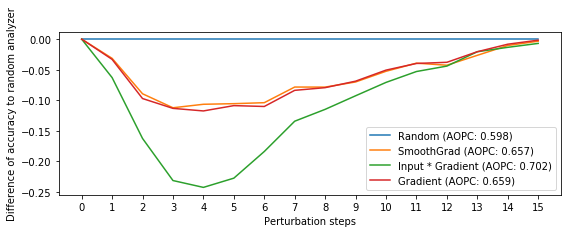

In [22]:
fig = plt.figure(figsize=(9, 3))
aopc = list()  # Area over the perturbation curve
for method_name in scores_selected_methods.keys():
    scores = scores_selected_methods[method_name]
    accuracy = scores[:, 1]
    aopc.append(accuracy[0] - np.mean(accuracy))
    
    label = "{} (AOPC: {:.3f})".format(method_name, aopc[-1])
    plt.plot(accuracy, label=label)
    
plt.xlabel("Perturbation steps")
plt.ylabel("Test accuracy")
plt.xticks(np.array(range(scores.shape[0])))
plt.legend()
plt.show()

As mentioned above, a steeper decrease shows a better identification of the relevant information.

## 2. Plot perturbed sample
Finally, we plot the perturbations on a selected test sample and show them along with the respective analyses.

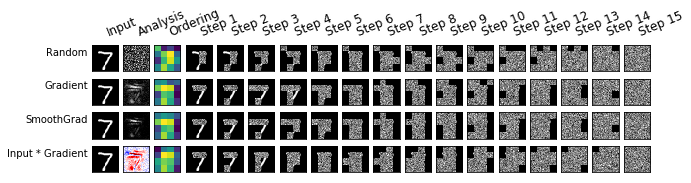

In [23]:
# Now plot the perturbation step by step.
plt.figure()
grid, row_labels = [], []
col_labels = ["Step {}".format(i) for i in range(steps+1)] + ["Analysis", "Ordering"]

for perturbation_analysis, method in zip(perturbation_analyses, selected_methods):
    row_labels.extend([[method[-1]], ["Sample:"]])
    samples = list()
    
    # Reset the perturbation_analysis
    perturbation_analysis.perturbation.num_perturbed_regions = 1

    sample = test_sample
    analysis = perturbation_analysis.analyzer.analyze(sample)

    # Divide into regions and order them according to their analysis score
    # TODO backend channel ordering
    aggregated_regions = perturbation_analysis.perturbation.reduce_function(np.moveaxis(analysis, 3, 1), axis=1, keepdims=True)
    aggregated_regions = perturbation_analysis.perturbation.aggregate_regions(aggregated_regions)
    ranks = perturbation_analysis.perturbation.compute_region_ordering(aggregated_regions)

    # Perturbate for some steps
    for i in range(steps+1):
        # Plot the original image and analysis without any perturbation
        if i > 0:
            perturbation_analysis.perturbation.num_perturbed_regions += perturbation_analysis.regions_per_step
            # Perturbate
            sample = perturbation_analysis.compute_on_batch(sample, analysis)
        # Apply common postprocessing, e.g., re-ordering the channels for plotting.
        sample_to_show = mnistutils.postprocess(sample.repeat(3, axis=-1))
        analysis = mnistutils.postprocess(analysis)
        # Apply analysis postprocessing, e.g., creating a heatmap.
        sample_to_show = np.clip(input_postprocessing(sample_to_show), 0, 1)

        samples.append(sample_to_show[0])    
    # Plot analysis
    analysis = method[2](analysis)
    
    samples.append(analysis[0])
    samples.append(-ranks[0][0])
        
    grid.extend([[None for x in samples], samples])
  
eutils.plot_image_grid(grid, row_labels, list(), col_labels, figsize=(10, 3))
plt.show()